<h1 style="text-align: center">Military Aircraft Detection Using Resnet, EfficientNet and GoogleNet</h1>

<h3 style="text-align:right">-By Aryan Gupta</h3>

In [1]:
%pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset/download?datasetVersionNumber=37")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aryagup
Your Kaggle Key: ··········


100%|██████████| 7.55G/7.55G [03:29<00:00, 38.6MB/s]


## Importing Important Libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import splitfolders
import matplotlib.pyplot as plt

In [5]:
# Splitting up dataset into Training and Validation
input_folder = "/content/militaryaircraftdetectiondataset/crop"
output = "/content/split-dataset1" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 12337 files [00:20, 594.30 files/s]


## Transformations on the dataset

Here we trying to attempt the following transformations and EDA to the given images before they are loaded into the data models.
- Converting the variable sized images into standard sizes of 224 X 224 so that they can be supplied to each next layer(ReSize)
- For images smaller than 224X224, I want randomcrop and padding(reflecting) enacbled as it can help increas the amount of data provided by low resolution images
- Then the images are converted into pytorch tensors
- Then the images are normalized using empirical values of mean and standard deviation

In [26]:

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224, padding=None, pad_if_needed=True, padding_mode='reflect'),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(224, padding=None, pad_if_needed=True, padding_mode='reflect'),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/content/split-dataset1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(class_names)

['A10', 'A400M', 'AG600', 'AV8B', 'B1', 'B2', 'B52', 'Be200', 'C130', 'C17', 'C5', 'E2', 'EF2000', 'F117', 'F14', 'F15', 'F16', 'F18', 'F22', 'F35', 'F4', 'J20', 'JAS39', 'MQ9', 'Mig31', 'Mirage2000', 'RQ4', 'Rafale', 'SR71', 'Su34', 'Su57', 'Tornado', 'Tu160', 'Tu95', 'U2', 'US2', 'V22', 'Vulcan', 'XB70', 'YF23']


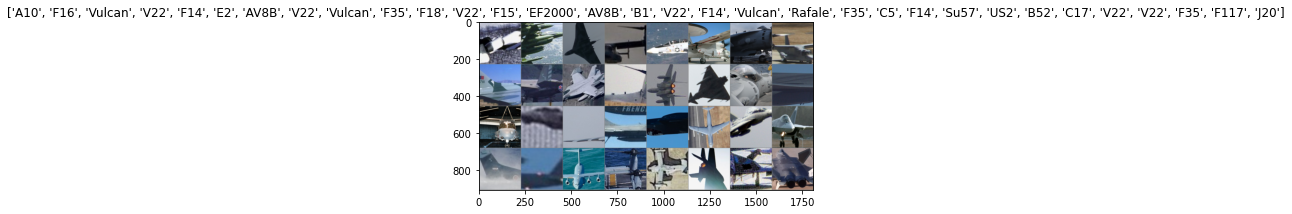

In [27]:

def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Creating a Standard Function for Dataloader

In [37]:
train_error_list = []
train_accuracy_list = []
val_error_list = []
val_accuracy_list = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_error_list.append(epoch_loss)
                train_accuracy_list.append(epoch_acc)
            if phase == 'val':
                val_error_list.append(epoch_loss)
                val_accuracy_list.append(epoch_acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
device = torch.device("cuda")

In [11]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Model Training

### 1. ResNet

In [30]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 40)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=8)

Epoch 1/8
----------
train Loss: 3.4976 Acc: 0.0939
val Loss: 3.6032 Acc: 0.0929

Epoch 2/8
----------
train Loss: 3.1192 Acc: 0.1619
val Loss: 3.1404 Acc: 0.1693

Epoch 3/8
----------
train Loss: 2.7385 Acc: 0.2547
val Loss: 2.7298 Acc: 0.2570

Epoch 4/8
----------
train Loss: 2.3280 Acc: 0.3561
val Loss: 2.6037 Acc: 0.3077

Epoch 5/8
----------
train Loss: 1.9889 Acc: 0.4412
val Loss: 2.2444 Acc: 0.4019

Epoch 6/8
----------
train Loss: 1.6510 Acc: 0.5397
val Loss: 2.0671 Acc: 0.4393

Epoch 7/8
----------
train Loss: 1.3723 Acc: 0.6054
val Loss: 2.2111 Acc: 0.4328

Epoch 8/8
----------
train Loss: 0.8732 Acc: 0.7581
val Loss: 1.5231 Acc: 0.5792

Training complete in 22m 1s
Best val Acc: 0.579244


In [31]:
train_accuracy_list = [(x.cpu().numpy()) for x in train_accuracy_list]

In [32]:
val_accuracy_list = [(x.cpu().numpy()) for x in val_accuracy_list]

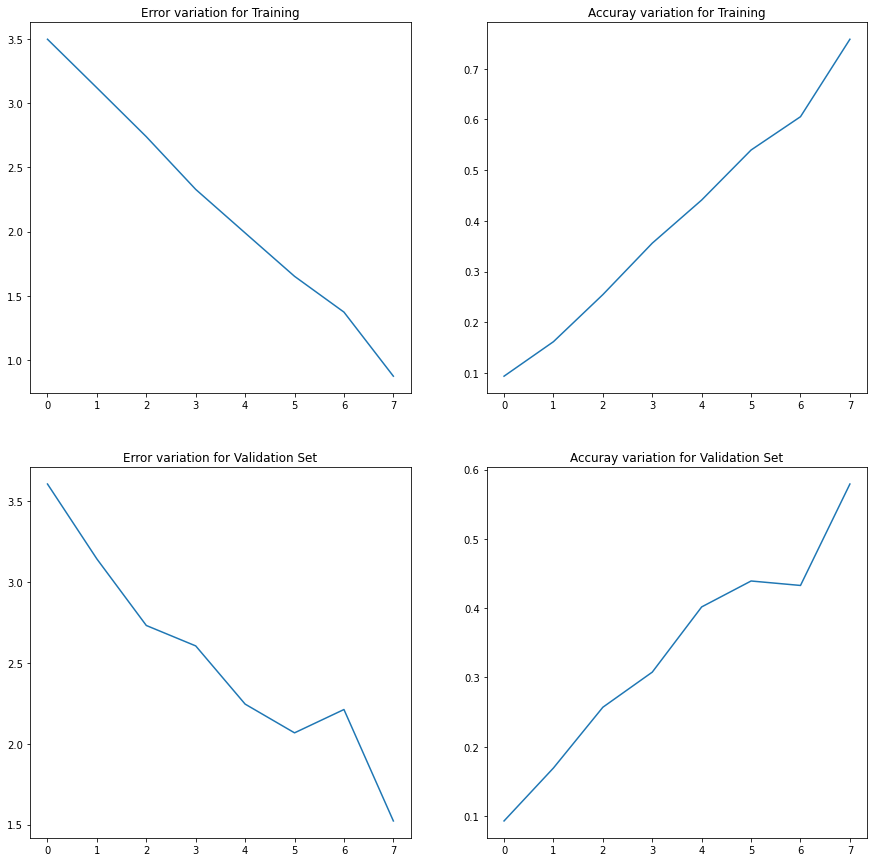

In [33]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 15))
  
# For Sine Function
axis[0, 0].plot([x for x in range(len(train_error_list))], train_error_list)
axis[0, 0].set_title("Error variation for Training")
  
axis[0, 1].plot([x for x in range(len(train_accuracy_list))], train_accuracy_list)
axis[0, 1].set_title("Accuray variation for Training")
# For Sine Function
axis[1, 0].plot([x for x in range(len(val_error_list))], val_error_list)
axis[1, 0].set_title("Error variation for Validation Set")
  
# For Tangent Function
axis[1, 1].plot([x for x in range(len(val_accuracy_list))], val_accuracy_list)
axis[1, 1].set_title("Accuray variation for Validation Set")
# Combine all the operations and display
plt.show()

### 2. EfficientNet

In [ ]:
# #### Finetuning the EFFICIENTNET_V2_S ####
# Load a pretrained model and reset final fully connected layer.

model = models.efficientnet_v2_s(pretrained=True)
#num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model.fc = nn.Linear(num_ftrs, 40)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=8)

In [ ]:
train_accuracy_list = [(x.cpu().numpy()) for x in train_accuracy_list]
val_accuracy_list = [(x.cpu().numpy()) for x in val_accuracy_list]
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 15))
  
# For Sine Function
axis[0, 0].plot([x for x in range(len(train_error_list))], train_error_list)
axis[0, 0].set_title("Error variation for Training")
  
axis[0, 1].plot([x for x in range(len(train_accuracy_list))], train_accuracy_list)
axis[0, 1].set_title("Accuray variation for Training")
# For Sine Function
axis[1, 0].plot([x for x in range(len(val_error_list))], val_error_list)
axis[1, 0].set_title("Error variation for Validation Set")
  
# For Tangent Function
axis[1, 1].plot([x for x in range(len(val_accuracy_list))], val_accuracy_list)
axis[1, 1].set_title("Accuray variation for Validation Set")
# Combine all the operations and display
plt.show()

In [39]:
# #### Finetuning the EFFICIENTNET_V2_S ####
# Load a pretrained model and reset final fully connected layer.

model = models.efficientnet_v2_s(pretrained=True)
#num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model.fc = nn.Linear(num_ftrs, 40)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=8)

Epoch 1/8
----------
train Loss: 6.2750 Acc: 0.0242
val Loss: 5.2580 Acc: 0.0563

Epoch 2/8
----------
train Loss: 4.9219 Acc: 0.0628
val Loss: 4.5854 Acc: 0.0704

Epoch 3/8
----------
train Loss: 4.4556 Acc: 0.0666
val Loss: 4.2708 Acc: 0.0732

Epoch 4/8
----------
train Loss: 4.1984 Acc: 0.0721
val Loss: 4.0758 Acc: 0.0792

Epoch 5/8
----------
train Loss: 4.0360 Acc: 0.0742
val Loss: 3.9490 Acc: 0.0805

Epoch 6/8
----------
train Loss: 3.9215 Acc: 0.0818
val Loss: 3.8406 Acc: 0.0857

Epoch 7/8
----------
train Loss: 3.8241 Acc: 0.0847
val Loss: 3.7655 Acc: 0.0973

Epoch 8/8
----------
train Loss: 3.7851 Acc: 0.0841
val Loss: 3.7547 Acc: 0.0925

Training complete in 35m 57s
Best val Acc: 0.097345


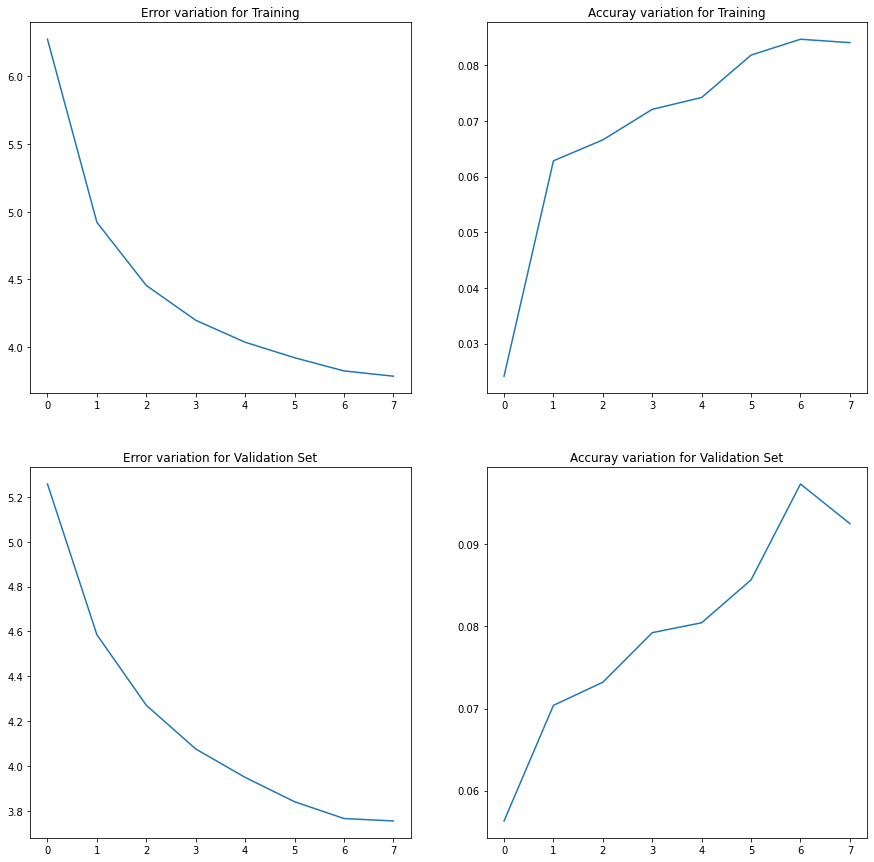

In [40]:
train_accuracy_list = [(x.cpu().numpy()) for x in train_accuracy_list]
val_accuracy_list = [(x.cpu().numpy()) for x in val_accuracy_list]
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 15))
  
# For Sine Function
axis[0, 0].plot([x for x in range(len(train_error_list))], train_error_list)
axis[0, 0].set_title("Error variation for Training")
  
axis[0, 1].plot([x for x in range(len(train_accuracy_list))], train_accuracy_list)
axis[0, 1].set_title("Accuray variation for Training")
# For Sine Function
axis[1, 0].plot([x for x in range(len(val_error_list))], val_error_list)
axis[1, 0].set_title("Error variation for Validation Set")
  
# For Tangent Function
axis[1, 1].plot([x for x in range(len(val_accuracy_list))], val_accuracy_list)
axis[1, 1].set_title("Accuray variation for Validation Set")
# Combine all the operations and display
plt.show()

### 3. GoogleNet

In [35]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.googlenet(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 40)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

Epoch 1/10
----------
train Loss: 3.6103 Acc: 0.0576
val Loss: 3.5423 Acc: 0.0772

Epoch 2/10
----------
train Loss: 3.5298 Acc: 0.0709
val Loss: 3.5050 Acc: 0.0813

Epoch 3/10
----------
train Loss: 3.4938 Acc: 0.0837
val Loss: 3.4738 Acc: 0.0897

Epoch 4/10
----------
train Loss: 3.4584 Acc: 0.0918
val Loss: 3.4383 Acc: 0.1030

Epoch 5/10
----------
train Loss: 3.4299 Acc: 0.1013
val Loss: 3.4070 Acc: 0.1062

Epoch 6/10
----------
train Loss: 3.3958 Acc: 0.1106
val Loss: 3.3811 Acc: 0.1134

Epoch 7/10
----------
train Loss: 3.3624 Acc: 0.1244
val Loss: 3.3493 Acc: 0.1279

Epoch 8/10
----------
train Loss: 3.3413 Acc: 0.1270
val Loss: 3.3438 Acc: 0.1319

Epoch 9/10
----------
train Loss: 3.3373 Acc: 0.1285
val Loss: 3.3407 Acc: 0.1279

Epoch 10/10
----------
train Loss: 3.3340 Acc: 0.1316
val Loss: 3.3371 Acc: 0.1291

Training complete in 30m 35s
Best val Acc: 0.131939


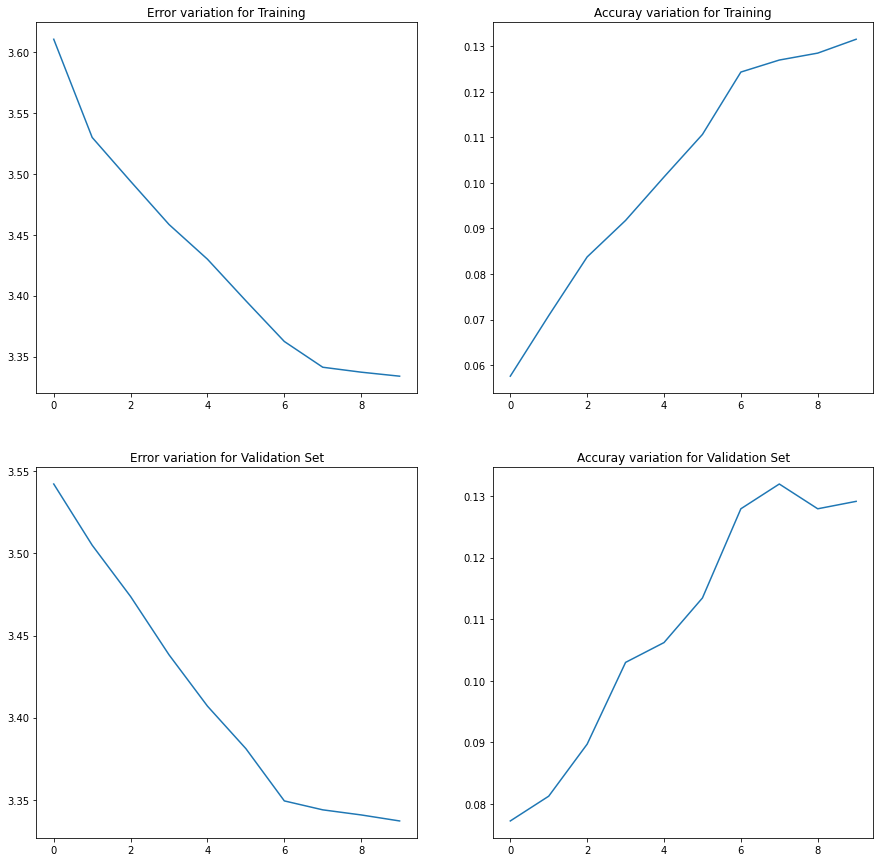

In [36]:
train_accuracy_list = [(x.cpu().numpy()) for x in train_accuracy_list]
val_accuracy_list = [(x.cpu().numpy()) for x in val_accuracy_list]
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2, figsize=(15, 15))
  
# For Sine Function
axis[0, 0].plot([x for x in range(len(train_error_list))], train_error_list)
axis[0, 0].set_title("Error variation for Training")
  
axis[0, 1].plot([x for x in range(len(train_accuracy_list))], train_accuracy_list)
axis[0, 1].set_title("Accuray variation for Training")
# For Sine Function
axis[1, 0].plot([x for x in range(len(val_error_list))], val_error_list)
axis[1, 0].set_title("Error variation for Validation Set")
  
# For Tangent Function
axis[1, 1].plot([x for x in range(len(val_accuracy_list))], val_accuracy_list)
axis[1, 1].set_title("Accuray variation for Validation Set")
# Combine all the operations and display
plt.show()